# Extraction of diffraction peaks from diffuse background

This example works by weighing the area under a
peak with positive values and surrounding the peak with a ring of
negative weight pixels in such a way that the total sum is 0. Applying
this mask to a constant background consequently yields 0, and only
differences between spot and surrounding ring show up in the result as
positive or negative values.

Sample data courtesy of Ian MacLaren <Ian.MacLaren@glasgow.ac.uk> and
Shane McCartan <s.mccartan.1@research.gla.ac.uk>, University of Glasgow

Sample preparation: David Hall and Ilkan Calisir

The dataset is from a solid solution ceramic of bismuth ferrite and barium 
titanate (ratio: 75%/25%) doped 3% Ti. Chemical segregation of the bismuth 
ferrite and barium titanate occurs in the formation of the core-shell type 
structure that you can see in the grain (barium titanate-shell, bismuth 
ferrite-core). The grain is orientated along the [110] direction as the 
extra spots that BFO produces at the 1/2 (111) positions are obvious in 
this orientation. Otherwise the diffraction patterns of BFO and BTO are 
too similar to distinguish easily.

## Set up the environment and import libraries

We disable threading in any numerics libraries because we already saturate the CPU with multiprocessing. Additional threads would get in each other's way and slow things down rather than speed them up. The environment variables have to be set as early as possible before any of the libraries are loaded.

In [1]:
import os
os.environ["OMP_NUM_THREADS"] = "1"
os.environ["MKL_NUM_THREADS"] = "1"
os.environ["OPENBLAS_NUM_THREADS"] = "1"

In [2]:
%matplotlib nbagg

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from libertem import api

## Create LiberTEM Context
Start a local cluster (default) or connect to a running cluster (TODO: To be implemented).

A warning about port 8787 being already in use can be ignored, that's only for cluster diagnostics.

In [4]:
ctx = api.Context()

## Load file
The parameters depend on the data set type. We can get basic information about the file from the dataset, for example its dimensions.

In [5]:
ds = ctx.load(
    "blo",
    path='C:/Users/weber/ownCloud/Projects/Open Pixelated STEM framework/Data/3rd-party Datasets/Glasgow/10 um 110.blo',
    tileshape=(1,8,144,144)
)

(scan_y, scan_x, detector_y, detector_x) = ds.shape
mask_shape = np.array((detector_y, detector_x))

## Extract a sample frame

Load and show a single frame at given coordinates in the data set. The coordinates were determined with the LiberTEM GUI in "pick" mode.

This function should not be used to load and process larger parts of a dataset since it sends the data through the cluster and performs calculations on the control node, not on the workers. Please contact the LiberTEM team if you have special processing in mind that is not optimally supported with the currently implemented job types!

<IPython.core.display.Javascript object>


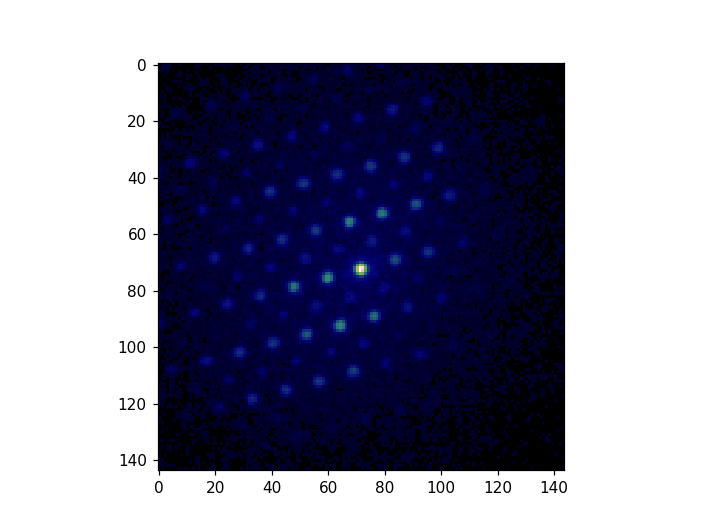

In [6]:
get_sample_frame = ctx.create_pick_job(dataset=ds, y=60, x=75)
sample_frame = ctx.run(get_sample_frame)
# Sample frame
fig, axes = plt.subplots()
axes.imshow(sample_frame, cmap=cm.gist_earth)

## Construct masks that extract peak families

`selector()` sets a local region of mask `buf` (passed by reference) around `center (x, y)` in such a way that pixels within `radius1`get assigned a weight of +1, while pixels between `radius1`and `radius2` get assigned a negative value in such a way that the net sum of the entire selector is exactly 0. When applied to a frame, this extracts the difference between the average value of pixels within `radius1` and the average value of pixels within the ring between `radius1`and `radius2`.

Sum:  2.842170943040401e-14


<IPython.core.display.Javascript object>


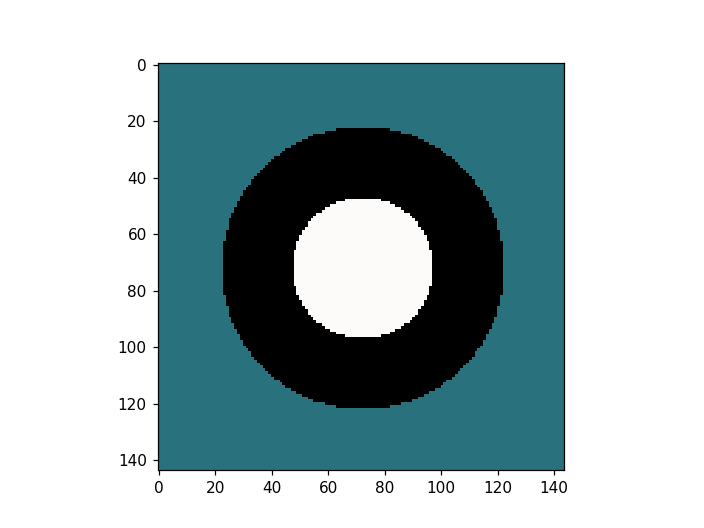

In [7]:
def selector(buf, center, radius1, radius2):
    (x, y) = center
    (max_y, max_x) = buf.shape
    radius1_2 = radius1**2
    radius2_2 = radius2**2
    inner = []
    outer = []
    bounding_radius = max(radius1, radius2)
    # calculate bounding box to save time
    left_x = int(max(0, np.floor(x - bounding_radius)))
    right_x = int(min(max_x - 1, np.ceil(x + bounding_radius)))
    up_y = int(max(0, np.floor(y - bounding_radius)))
    down_y = int(min(max_y - 1 , np.ceil(y + bounding_radius)))
    
    # register which pixels are in the inner resp. outer region of the peak selector
    for i in range(left_x, right_x + 1):
        for j in range(up_y, down_y + 1):
            if ((i-x)**2 + (j-y)**2 < radius1_2): 
                inner.append((i, j))
            elif ((i-x)**2 + (j-y)**2 < radius2_2):
                outer.append((i,j))
    # set inner ones to 1            
    for (i, j) in inner:
        buf[j, i] = 1
    # if we have any outer pixels:
    # set them to a negative number so that the total sum around a peak is 0
    # That means applying this mask to a constant background yields 0
    if (len(outer) > 0):
        outer_num = len(inner) / len(outer)
        for (i, j) in outer:
            buf[j, i] = -outer_num
            
sample_mask = np.zeros(mask_shape)

selector(sample_mask, mask_shape / 2, 25, 50)

print("Sum: ", sample_mask.sum())

fig, axes = plt.subplots()
axes.imshow(sample_mask, cmap=cm.gist_earth)

## Construct a parallelogram grid

For better signal-to-noise ratio and less sensitivity to the exact diffraction conditions we want to sum up data from many corresponding peaks. We could just list all the coordinates by hand, but that's a bit tedious. Instead, we use three corner peaks and the number of peaks in each dimension to span a parallelogram grid

For a more fancy version, one could use computational crystallography to calculate the positions. 

In [8]:
# "count" parameter includes the corner peaks
def peak_grid(upper_left, upper_right, lower_left, count_x, count_y, skip=[]):
    coords = []
    upper_left = np.array(upper_left)
    upper_right = np.array(upper_right)
    lower_left = np.array(lower_left)
    # calculate the grid positions
    for x in range(count_x):
        for y in range(count_y):
            if (x, y) in skip:
                continue
            start = upper_left
            delta_a = (upper_right - upper_left)*x/(count_x - 1)
            delta_b = (lower_left - upper_left)*y/(count_y - 1)
            coords.append(start + delta_a + delta_b)
    return coords

## Masks with actual peak positions

The LiberTEM Mask job accepts argument-less functions as parameters that have the mask as an output. That way, the mask is not sent through the cluster, only the function that builds it.

The coordinates and peak sizes were picked with the LiberTEM GUI in "pick" mode.

In [9]:
def super_peaks():
    buf = np.zeros(mask_shape)
    # inner and outer radius of peak selector
    inner = 2
    outer = 5
    # instead of selecting and typing all coordinates of the peaks, 
    # we calculate a grid from three corner points and the number of peaks in X and y
    coords = peak_grid(
        (7.2, 44.8),
        (91.5, 22.4),
        (28.8, 127.8),
        8,
        6
    )
    # Apply the peak positions to the mask
    for (x, y) in coords:
        selector(buf, (x, y), inner, outer)
    return buf

def base_peaks():    
    buf = np.zeros(mask_shape)
    inner = 2
    outer = 5
    coords = peak_grid(
        (10.8, 34.8),
        (105.9, 11.0),
        (37.4, 134.7),
        9,
        7,
        # skip the zero-order peak
        skip=[(4, 3)]
    )
    for (x, y) in coords:
        selector(buf, (x, y), inner, outer)
    return buf

## Show the resulting masks

<IPython.core.display.Javascript object>


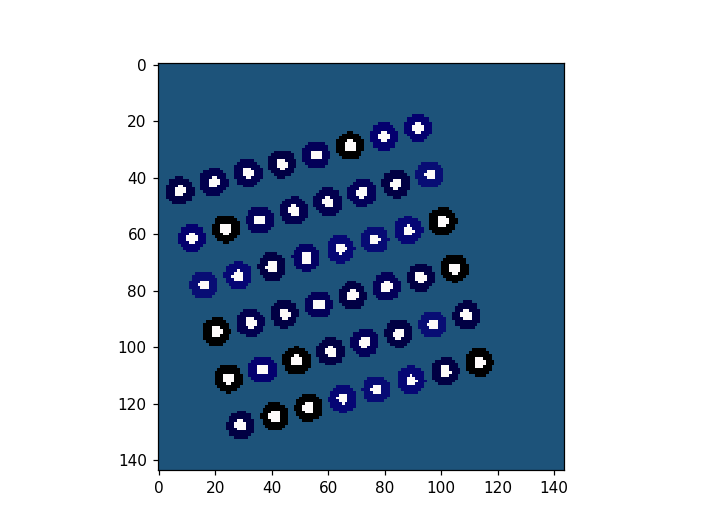

<IPython.core.display.Javascript object>


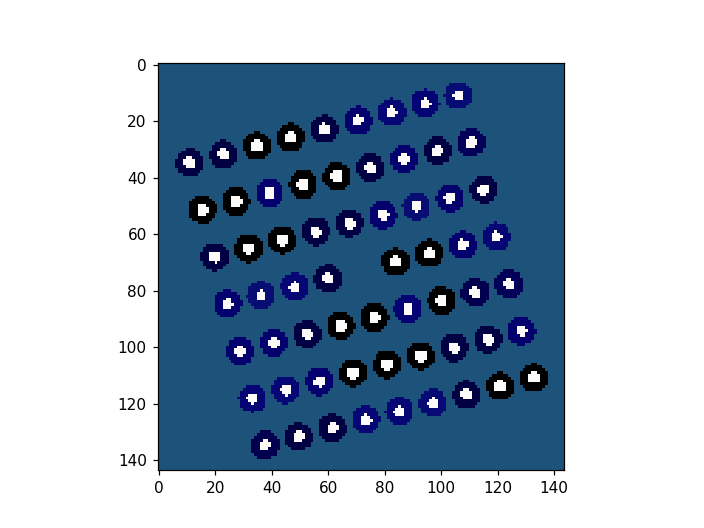

In [10]:
fig, axes = plt.subplots()
axes.imshow(super_peaks(), cmap=cm.gist_earth)

fig, axes = plt.subplots()
axes.imshow(base_peaks(), cmap=cm.gist_earth)

## Confirm peak positions

Superimpose the sample frame with the calculated peak positions to see if we got positions and sizes right. The mask is substracted from the sample frame to get a clearer picture.

<IPython.core.display.Javascript object>


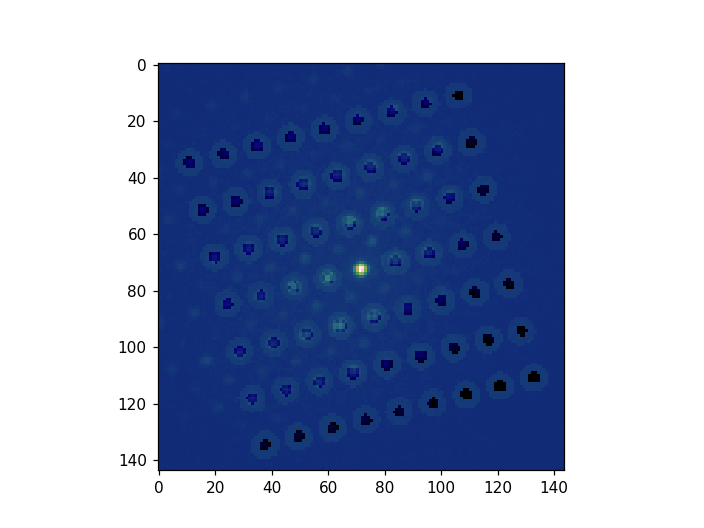

<IPython.core.display.Javascript object>


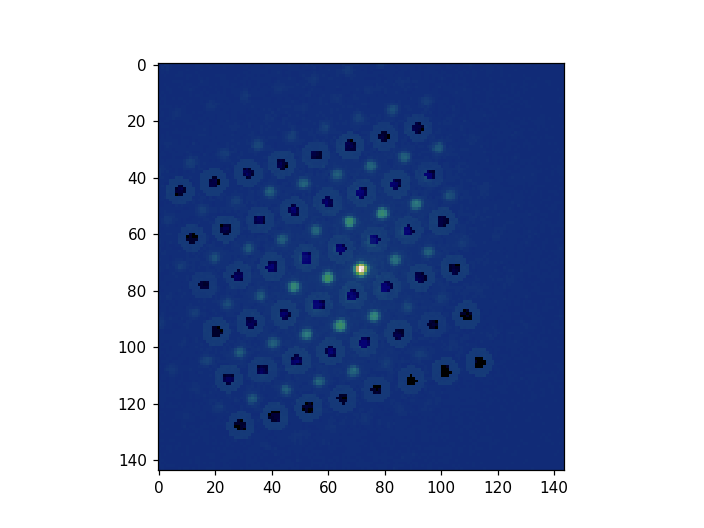

In [11]:


# Check if we got the selectors at the right spot:
# superimposed with base peaks
fig, axes = plt.subplots()
axes.imshow(sample_frame/30 - base_peaks(), cmap=cm.gist_earth)
# superimposed with superlattice peaks
fig, axes = plt.subplots()
axes.imshow(sample_frame/30 - super_peaks(), cmap=cm.gist_earth)

## Create a job for execution

LiberTEM works by creating Jobs that are then sent to the Context for execution. A Mask Job multiplies the given masks element-wise with each frame and returns the sum of the result for each mask and frame as a 3D array. The first dimension are the masks the second and third the Y and X direction of scanning.

In [12]:
analysis = ctx.create_mask_analysis(factories=[super_peaks, base_peaks], dataset=ds)

## Execute the job

The convention of the LiberTEM API is that only an explicit call of `run()` will perform work on the cluster. 

In [13]:
%%time
result = ctx.run(analysis)

Wall time: 2.96 s


## Show the result

In [14]:
print(result)

[<AnalysisResult: mask_0>, <AnalysisResult: mask_1>]


In [15]:
print(result.mask_0, result.mask_1)

title: mask 0
desc: intensity for mask 0
key: mask_0
raw_data: [[  -8.840714   -14.64247    -58.936394  ...  -89.326294   -61.455334
   -62.728004 ]
 [ -16.95898    -19.34586    -23.501657  ...  -57.024746   -40.77909
   -57.278774 ]
 [ -51.197235   -44.870502   -21.144445  ...  -86.924095   -65.18539
   -69.30334  ]
 ...
 [-108.22366    -99.28694   -117.6741    ...  -14.122009   -16.566532
    -7.9618263]
 [  -2.9893408   -3.469188    -6.523252  ...  -24.51238    -11.607451
   -10.235616 ]
 [   0.           0.           0.        ...  -23.206436    -8.6967325
   -13.912411 ]]
visualized: [[[ 30  84 122 255]
  [ 30  84 122 255]
  [ 29  83 122 255]
  ...
  [ 29  81 122 255]
  [ 29  83 122 255]
  [ 29  81 122 255]]

 [[ 30  84 122 255]
  [ 30  84 122 255]
  [ 30  84 122 255]
  ...
  [ 29  83 122 255]
  [ 29  83 122 255]
  [ 29  83 122 255]]

 [[ 29  83 122 255]
  [ 29  83 122 255]
  [ 30  84 122 255]
  ...
  [ 29  81 122 255]
  [ 29  81 122 255]
  [ 29  81 122 255]]

 ...

 [[ 28  79 122

<IPython.core.display.Javascript object>


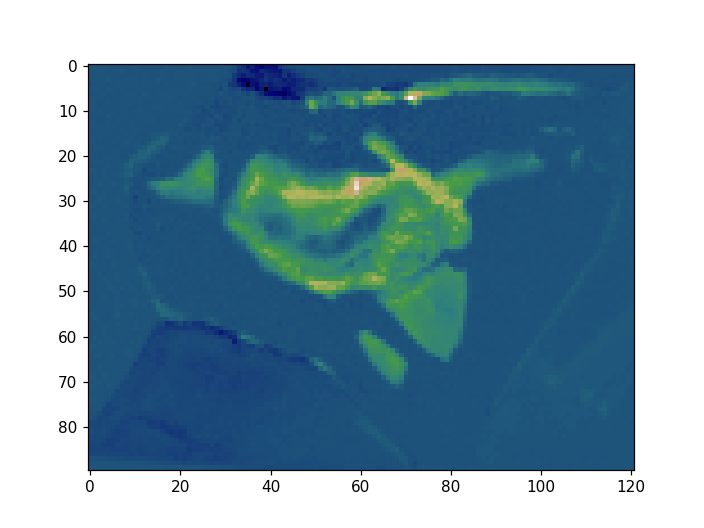

<IPython.core.display.Javascript object>


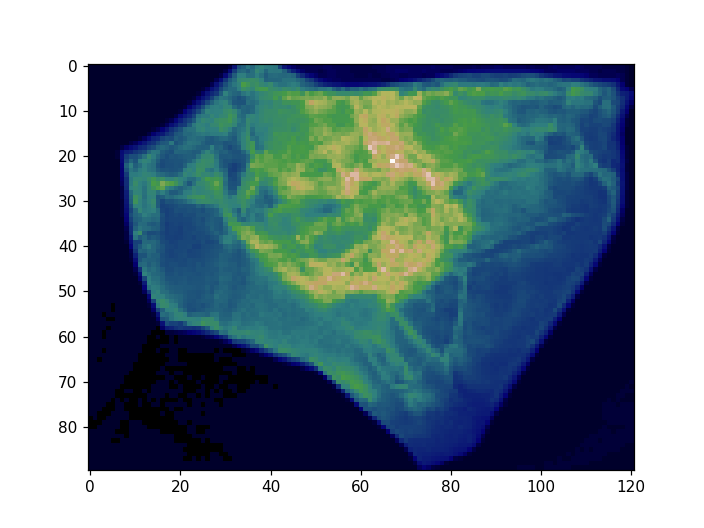

In [16]:
fig, axes = plt.subplots()
axes.imshow(result.mask_0.visualized)

fig, axes = plt.subplots()
axes.imshow(result.mask_1.visualized)